In [ ]:
!git clone --single-branch --branch v0.2dev https://github.com/scikit-learn-contrib/py-earth.git
%cd py-earth
!python setup.py install --cythonize

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score,train_test_split,\
GridSearchCV, ParameterGrid, KFold, StratifiedKFold, cross_val_predict, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, precision_recall_curve, \
roc_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix, mean_squared_error
from sklearn.tree import DecisionTreeRegressor, export_graphviz,DecisionTreeClassifier
from sklearn.ensemble import BaggingRegressor,BaggingClassifier, RandomForestRegressor,RandomForestClassifier,\
AdaBoostRegressor,AdaBoostClassifier,GradientBoostingRegressor,GradientBoostingClassifier
from six import StringIO
from IPython.display import Image  
import pydotplus
import time as tm
import itertools as it
from pyearth import Earth
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data quality check / cleaning / preparation 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.** An example is given below.

In [2]:
data=pd.read_csv('Medicalpremium.csv')
y = data['PremiumPrice']
X = data.drop(columns = 'PremiumPrice')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 45)
train=pd.concat([X_train,y_train],axis=1)
test=pd.concat([X_test,y_test],axis=1)
data.head()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
0,45,0,0,0,0,155,57,0,0,0,25000
1,60,1,0,0,0,180,73,0,0,0,29000
2,36,1,1,0,0,158,59,0,0,1,23000
3,52,1,1,0,1,183,93,0,0,2,28000
4,38,0,0,0,1,166,88,0,0,1,23000


## Exploratory data analysis

<Axes: xlabel='PremiumPrice', ylabel='Count'>

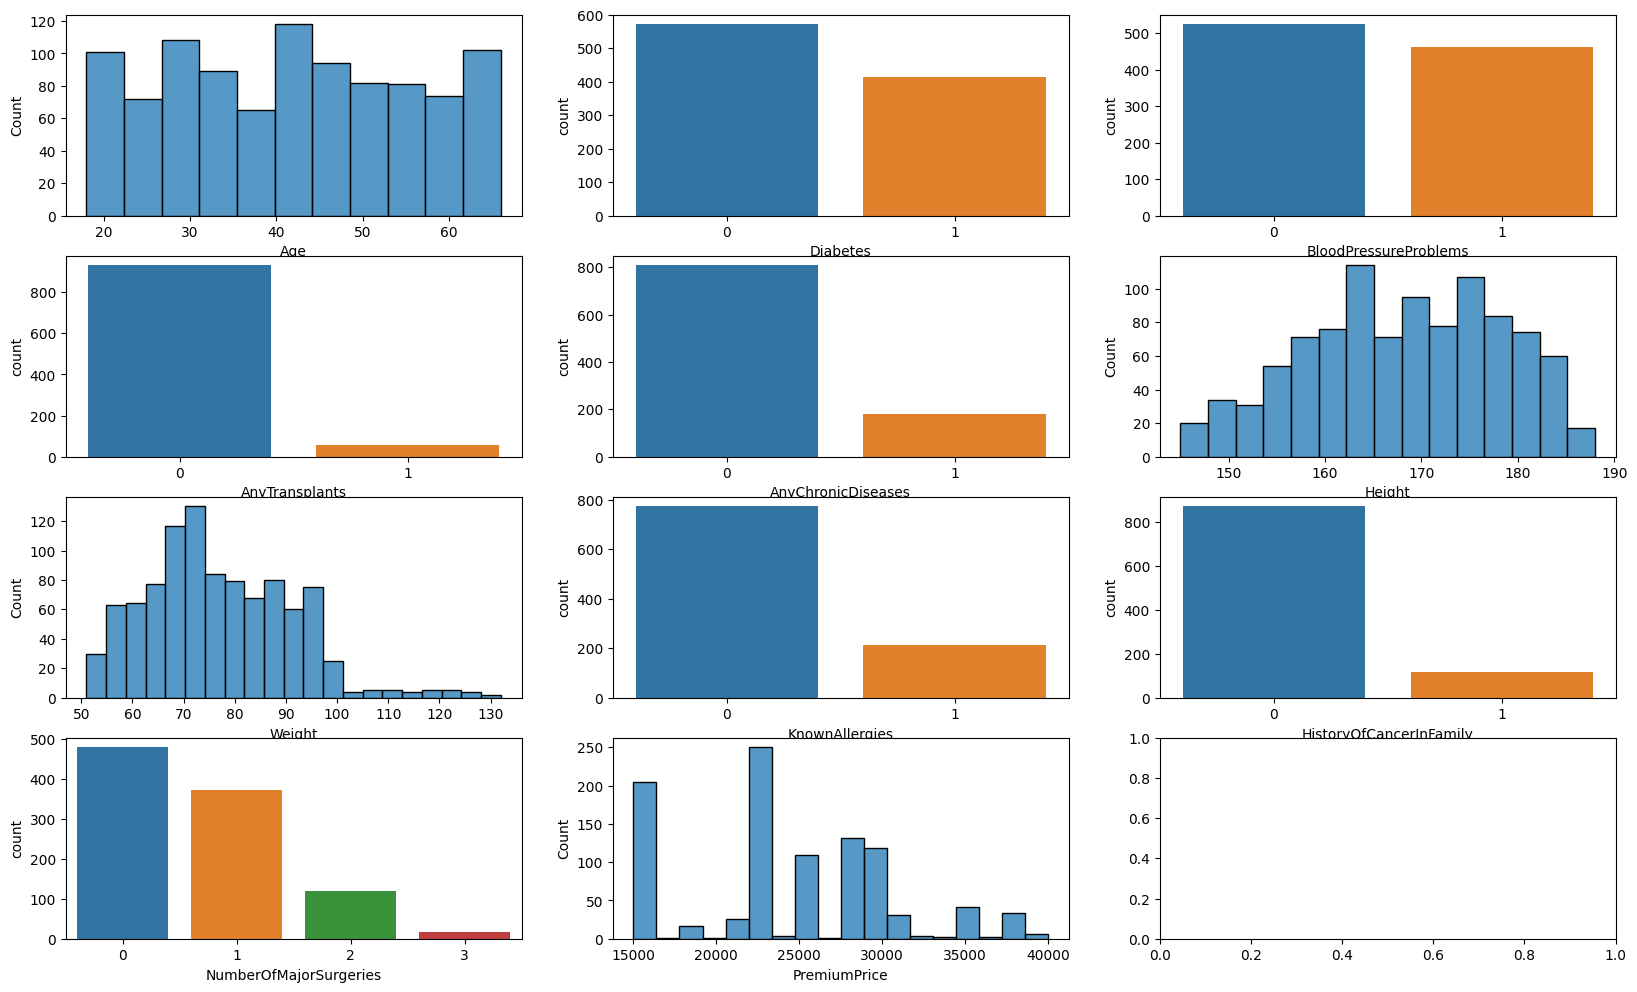

In [ ]:
fig, axes = plt.subplots(4,3,figsize=(20,12))
plt.subplots_adjust(wspace=0.2)
sns.histplot(data=data,x='Age',ax=axes[0,0])
sns.countplot(data=data,x='Diabetes',ax=axes[0,1])
sns.countplot(data=data,x='BloodPressureProblems',ax=axes[0,2])
sns.countplot(data=data,x='AnyTransplants',ax=axes[1,0])
sns.countplot(data=data,x='AnyChronicDiseases',ax=axes[1,1])
sns.histplot(data=data,x='Height',ax=axes[1,2])
sns.histplot(data=data,x='Weight',ax=axes[2,0])
sns.countplot(data=data,x='KnownAllergies',ax=axes[2,1])
sns.countplot(data=data,x='HistoryOfCancerInFamily',ax=axes[2,2])
sns.countplot(data=data,x='NumberOfMajorSurgeries',ax=axes[3,0])
sns.histplot(data=data,x='PremiumPrice',ax=axes[3,1])

<Axes: >

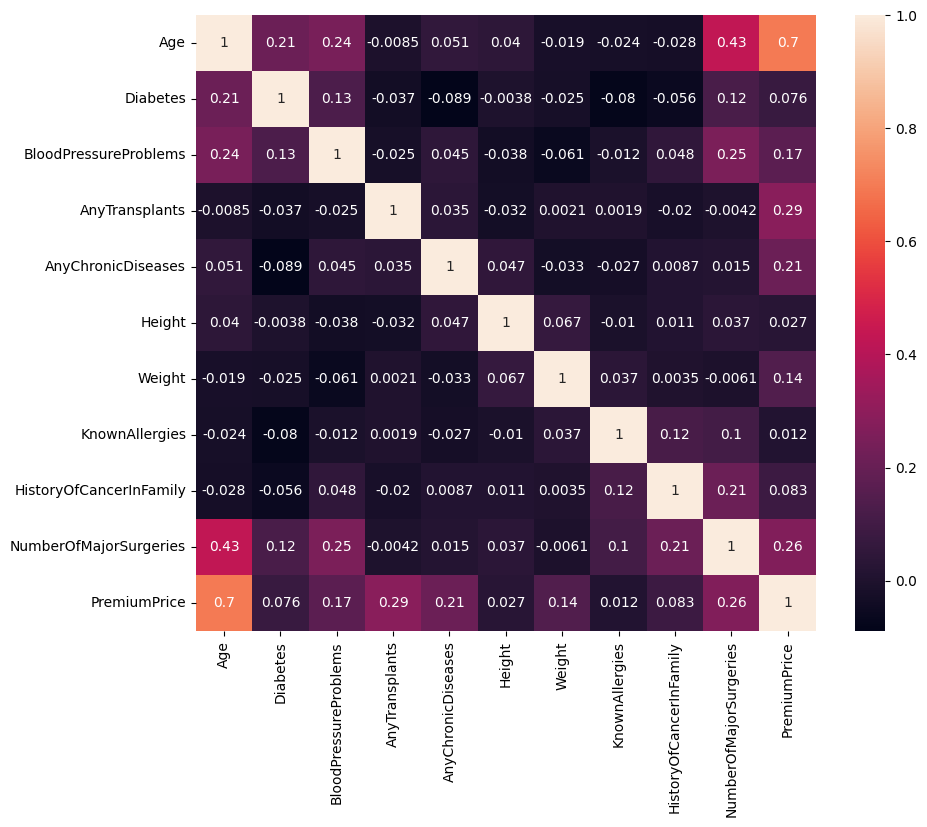

In [ ]:
corr_table = data.corr()

%matplotlib inline 
plt.figure(figsize=(10,8))
sns.heatmap(corr_table,annot=True)

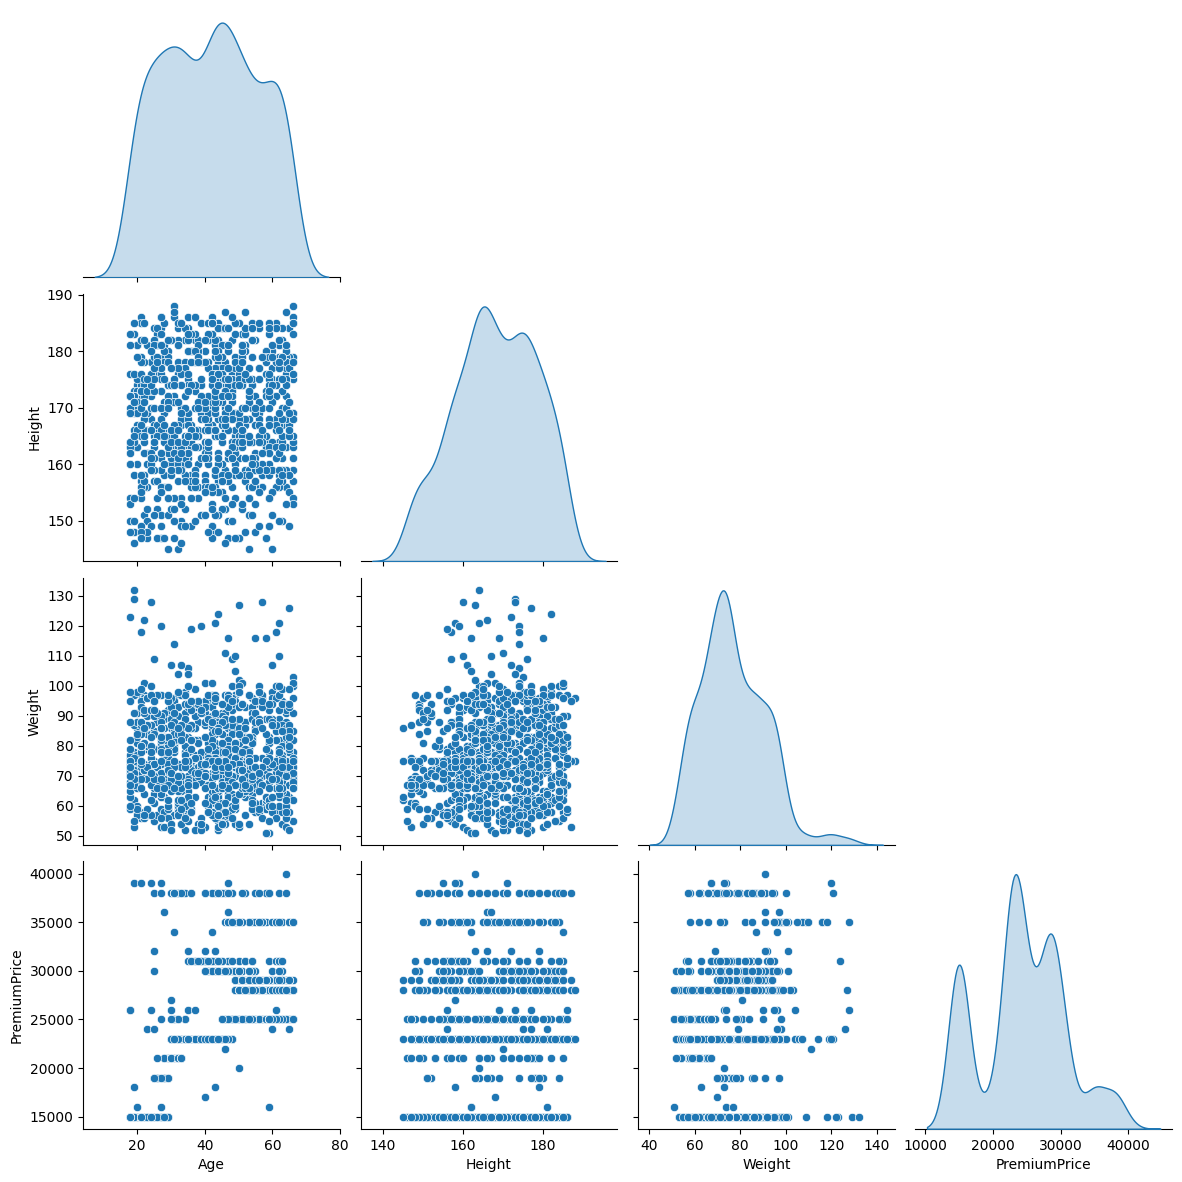

In [ ]:
sns.pairplot(data=data[['Age','Height','Weight','PremiumPrice']],corner=True,diag_kind="kde",height=3)

# BASE BASE MODEL
This uses the three predictors with the highest correlation with `PremiumPrice`.

In [ ]:
model = smf.ols(formula = 'PremiumPrice~Age+AnyTransplants+NumberOfMajorSurgeries', data = train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           PremiumPrice   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     339.2
Date:                Mon, 05 Jun 2023   Prob (F-statistic):          3.88e-141
Time:                        20:36:34   Log-Likelihood:                -7679.6
No. Observations:                 788   AIC:                         1.537e+04
Df Residuals:                     784   BIC:                         1.539e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               1.088e+04    465.274     23.383      0.000    9966.118    1.18e+04
Age                      317.5042     11.481     27.654      0.000     294.967     340.042
AnyTransplants          7185.3514    629.612     11.412      0.000    5949.427    8421.276
NumberOfMajorSurgeries  -306.7371    216.447     -1.417      0.157    -731.621     118.147
==============================================================================
Omnibus:                      195.121   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              630.095
Skew:                           1.179   Prob(JB):                    1.50e-137
Kurtosis:                       6.692   Cond. No.                         189.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
pred_price = model.predict(test)
print('RMSE =', np.sqrt(mean_squared_error(pred_price,y_test)))

RMSE = 3839.204228844269


## Initial MARS Model

In [ ]:
model = Earth(max_terms=500, max_degree=1).fit(X_train,y_train)
print(model.summary())

Earth Model
----------------------------------------------
Basis Function           Pruned  Coefficient  
----------------------------------------------
(Intercept)              No      5026.67      
Age                      No      326.136      
AnyTransplants           No      7080.64      
Weight                   No      67.9015      
AnyChronicDiseases       No      2446.8       
HistoryOfCancerInFamily  No      2415.8       
NumberOfMajorSurgeries   No      -541.233     
Diabetes                 No      -697.258     
h(Weight-119)            Yes     None         
h(119-Weight)            Yes     None         
h(Weight-119)            Yes     None         
h(119-Weight)            Yes     None         
----------------------------------------------
MSE: 14494617.7355, GCV: 15199942.7747, RSQ: 0.6307, GRSQ: 0.6137


In [ ]:
pred = model.predict(X_test)
print('RMSE =', np.sqrt(mean_squared_error(pred,y_test)))

RMSE = 3478.394228999356


In [ ]:
rmse_df = pd.DataFrame(columns = ['degree', 'RMSE'])
counter = 0
for degree in np.arange(1, 10, 1):
    rmse_df.loc[counter, 'RMSE'] = np.sqrt(np.mean(-cross_val_score(Earth(max_terms=1000, max_degree = degree),
                                 X_train, y_train, scoring='neg_mean_squared_error', n_jobs=-1)))
    rmse_df.loc[counter, 'degree'] = degree
    counter = counter + 1

In [ ]:
rmse_df

,degree,RMSE
0,1,3910.595925
1,2,3666.073468
2,3,3732.098627
3,4,3709.334719
4,5,3727.544391
5,6,3729.024559
6,7,3718.863482
7,8,3721.367236
8,9,9280.926355


In [ ]:
rmse_df.loc[np.argmin(rmse_df.RMSE),:]

degree              2
RMSE      3666.073468
Name: 1, dtype: object

In [ ]:
model = Earth(max_terms=500, max_degree=2).fit(X_train,y_train)
pred = model.predict(X_test)
print('RMSE =', np.sqrt(mean_squared_error(pred,y_test)))

RMSE = 3140.038914153902


In [ ]:
params = {'base_estimator': [Earth(max_terms=500, max_degree=2)],
          'n_estimators': [150,200],
          'max_samples': [0.8,1.0],
          'max_features': [0.8,1.0],
          'bootstrap': [True,False],
          'bootstrap_features': [True,False]}

cv = KFold(n_splits=3,shuffle=True,random_state=1)
bagging_mars_grid = RandomizedSearchCV(BaggingRegressor(random_state=1, n_jobs=-1), 
                                 param_distributions=params, cv=cv, n_jobs=-1, 
                                 verbose=1, scoring='neg_mean_squared_error',
                                 n_iter=32, random_state=1)
bagging_mars_grid.fit(X_train, y_train)

print('Train RMSE Score : %.3f'%bagging_mars_grid.best_estimator_.score(X_train, y_train))
print('Test RMSE Score : %.3f'%bagging_mars_grid.best_estimator_.score(X_test, y_test))
print('Best RMSE Score Through Grid Search : %.3f'%bagging_mars_grid.best_score_)
print('Best Parameters : ',bagging_mars_grid.best_params_)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Train RMSE Score : 0.705
Test RMSE Score : 0.742
Best RMSE Score Through Grid Search : -13475950.918
Best Parameters :  {'n_estimators': 200, 'max_samples': 1.0, 'max_features': 1.0, 'bootstrap_features': False, 'bootstrap': True, 'base_estimator': Earth(max_degree=2, max_terms=500)}


In [ ]:
params = {'base_estimator': [Earth(max_terms=500, max_degree=2)],
          'n_estimators': [200],
          'max_samples': np.arange(0.89,0.911,0.002),
          'max_features': np.arange(0.96,0.981,0.002),
          'bootstrap': [True],
          'bootstrap_features': [False]}

cv = KFold(n_splits=2,shuffle=True,random_state=1)
bagging_mars_grid = RandomizedSearchCV(BaggingRegressor(random_state=1, n_jobs=-1), 
                                 param_distributions=params, cv=cv, n_jobs=-1, 
                                 verbose=1, scoring='neg_mean_squared_error',
                                 n_iter=10, random_state=1)
bagging_mars_grid.fit(X_train, y_train)

print('Train RMSE Score : %.3f'%bagging_mars_grid.best_estimator_.score(X_train, y_train))
print('Test RMSE Score : %.3f'%bagging_mars_grid.best_estimator_.score(X_test, y_test))
print('Best RMSE Score Through Grid Search : %.3f'%bagging_mars_grid.best_score_)
print('Best Parameters : ',bagging_mars_grid.best_params_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
Train RMSE Score : 0.698
Test RMSE Score : 0.724
Best RMSE Score Through Grid Search : -13144341.403
Best Parameters :  {'n_estimators': 200, 'max_samples': 0.9, 'max_features': 0.974, 'bootstrap_features': False, 'bootstrap': True, 'base_estimator': Earth(max_degree=2, max_terms=500)}


In [ ]:
np.sqrt(-bagging_mars_grid.best_score_)

3625.5125711318105

# Regular Basic GOOD Model

In [ ]:
#the overarching important scoring
basicmodel = DecisionTreeRegressor(random_state=45) 
basicmodel = basicmodel.fit(X_train, y_train)

In [ ]:
np.sqrt(mean_squared_error(y_test, basicmodel.predict(X_test)))

2915.4759474226503

# Random Forest L

In [ ]:
##grid search for params 

param_grid = {
    'max_depth': [12,15,18],
    'max_leaf_nodes': range(25,250, 50),
    'max_features': range(1,4),
    'n_estimators': range(1,30,10)
}
skf = StratifiedKFold(n_splits=5)

grid = GridSearchCV(RandomForestRegressor(random_state=45), param_grid, scoring= 'neg_mean_squared_error', cv=skf, n_jobs=-1, verbose = True)

grid.fit(X_train,y_train)
grid.best_estimator_

Fitting 5 folds for each of 135 candidates, totalling 675 fits


RandomForestRegressor(max_depth=15, max_features=3, max_leaf_nodes=225,
                      n_estimators=21, random_state=45)

In [ ]:
print(np.sqrt(grid.best_score_)) # Best accuracy that the grid returns
print(grid.best_params_) # Best hyperparam combo
cv_results = pd.DataFrame(grid.cv_results_)

nan
{'max_depth': 15, 'max_features': 3, 'max_leaf_nodes': 225, 'n_estimators': 21}


In [ ]:
rf_final = RandomForestRegressor(n_estimators=grid.best_params_['n_estimators'],max_depth=grid.best_params_['max_depth'],
max_leaf_nodes=grid.best_params_['max_leaf_nodes'],max_features=grid.best_params_['max_features'],random_state= 42)

In [ ]:
rf_final=rf_final.fit(X_train,y_train)

In [ ]:
np.sqrt(mean_squared_error(y_test, rf_final.predict(X_test)))

2736.0580415604586

In [ ]:
imp = rf_final.feature_importances_

fi_df = pd.DataFrame(columns = ['predictor', 'rank'])
fi_df.loc[:, 'predictor'] = X_train.columns
fi_df.loc[:, 'rank'] = imp
fi_df = fi_df.sort_values('rank', ascending = False)
print(fi_df)

                 predictor      rank
0                      Age  0.591302
6                   Weight  0.117328
3           AnyTransplants  0.086449
5                   Height  0.066020
9   NumberOfMajorSurgeries  0.046415
4       AnyChronicDiseases  0.032599
2    BloodPressureProblems  0.021369
8  HistoryOfCancerInFamily  0.018237
1                 Diabetes  0.011421
7           KnownAllergies  0.008860


# Random Forest -- max features and bootstrap check

In [ ]:
params = {'max_features': range(1,26), 
          'bootstrap': [True, False]}

cv = KFold(n_splits=5, shuffle=True, random_state=45)

rf_grid = GridSearchCV(RandomForestRegressor(random_state=45, n_jobs=-1, n_estimators=150), param_grid = params, cv=cv,
                       n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')

rf_grid.fit(X_train, y_train)
print(rf_grid.best_score_, rf_grid.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
-8150705.186379639 {'bootstrap': True, 'max_features': 9}


In [ ]:
rf2 = RandomForestRegressor(random_state=45, max_features =9,bootstrap = True) 
rf2.fit(X_train, y_train)

np.sqrt(mean_squared_error(y_test, rf2.predict(X_test)))

2509.740720641972

In [ ]:
rf2 = RandomForestRegressor(random_state=45, max_features =9,bootstrap = False) 
rf2.fit(X_train, y_train)

np.sqrt(mean_squared_error(y_test, rf2.predict(X_test)))

2423.6041489292493

# Random Forest -- max_leaf_nodes, max_depth

In [ ]:
params = {'max_leaf_nodes': range(100,500,100), 
          'max_depth': [5,10,15,20,25,30,35]}

cv = KFold(n_splits=5, shuffle=True, random_state=45)

rf_grid = GridSearchCV(RandomForestRegressor(random_state=45, n_jobs=-1, n_estimators=150, max_features =9,bootstrap = True), 
                       param_grid = params, cv=cv,
                       n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')
rf_grid.fit(X_train, y_train)
print(rf_grid.best_score_, rf_grid.best_params_)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
-8414949.152049337 {'max_depth': 10, 'max_leaf_nodes': 100}


In [ ]:
rf2 = RandomForestRegressor(random_state=45, max_features =9, max_depth =10, max_leaf_nodes = 100, bootstrap = True) 
rf2.fit(X_train, y_train)

np.sqrt(mean_squared_error(y_test, rf2.predict(X_test)))

2533.4067688797904

In [ ]:
rf2 = RandomForestRegressor(random_state=45, max_features =9, max_depth =10, max_leaf_nodes = 100, bootstrap = False) 
rf2.fit(X_train, y_train)
np.sqrt(mean_squared_error(y_test, rf2.predict(X_test)))

2477.168878045213

In [ ]:
cv_results = pd.DataFrame(rf_grid.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_leaf_nodes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.635694,0.046038,0.045834,0.003896,5,100,"{'max_depth': 5, 'max_leaf_nodes': 100}",-8.432883e+06,-1.206444e+07,-1.188258e+07,-4.115404e+06,-9.209993e+06,-9.141060e+06,2.892251e+06,25
1,0.567865,0.065885,0.047186,0.005019,5,200,"{'max_depth': 5, 'max_leaf_nodes': 200}",-8.432883e+06,-1.206444e+07,-1.188258e+07,-4.115404e+06,-9.209993e+06,-9.141060e+06,2.892251e+06,27
2,0.714735,0.071201,0.048253,0.007776,5,300,"{'max_depth': 5, 'max_leaf_nodes': 300}",-8.432883e+06,-1.206444e+07,-1.188258e+07,-4.115404e+06,-9.209993e+06,-9.141060e+06,2.892251e+06,27
3,0.692279,0.075448,0.052627,0.005493,5,400,"{'max_depth': 5, 'max_leaf_nodes': 400}",-8.432883e+06,-1.206444e+07,-1.188258e+07,-4.115404e+06,-9.209993e+06,-9.141060e+06,2.892251e+06,25
4,0.717348,0.071967,0.046695,0.006023,10,100,"{'max_depth': 10, 'max_leaf_nodes': 100}",-7.275906e+06,-1.121982e+07,-1.054932e+07,-4.751795e+06,-8.277905e+06,-8.414949e+06,2.330568e+06,1


Text(0, 0.5, 'K-fold MAE')

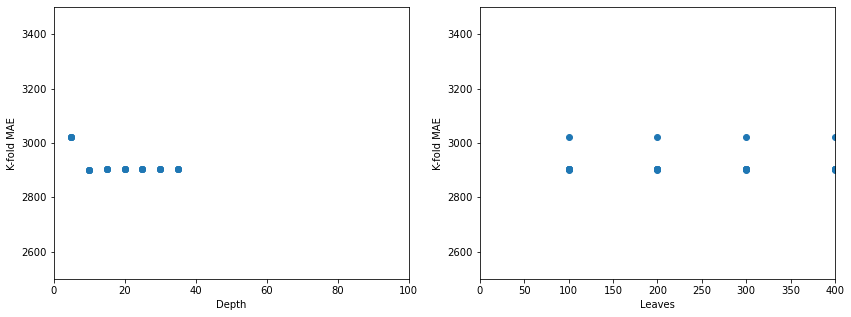

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(14,5))
plt.subplots_adjust(wspace=0.2)
axes[0].plot(cv_results.param_max_depth, np.sqrt(-cv_results.mean_test_score), 'o')
axes[0].set_xlim([0,100])
axes[0].set_ylim([2500,3500])
axes[0].set_xlabel('Depth')
axes[0].set_ylabel('K-fold MAE')
axes[1].plot(cv_results.param_max_leaf_nodes, np.sqrt(-cv_results.mean_test_score), 'o')
axes[1].set_xlim([0,400])
axes[1].set_ylim([2500,3500])
axes[1].set_xlabel('Leaves')
axes[1].set_ylabel('K-fold MAE')

# zoom in corse grid search on max_leaf_nodes

In [ ]:
params = {'max_leaf_nodes': range(25,75,5), 
          'max_depth': [1,3,5,7]}

cv = KFold(n_splits=5, shuffle=True, random_state=45)

rf_grid = GridSearchCV(RandomForestRegressor(random_state=45, n_jobs=-1, n_estimators=150, max_features =9,bootstrap = True), 
                       param_grid = params, cv=cv,
                       n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')
rf_grid.fit(X_train, y_train)
print(rf_grid.best_score_, rf_grid.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
-8140719.147659878 {'max_depth': 7, 'max_leaf_nodes': 25}


In [ ]:
rf2 = RandomForestRegressor(random_state=45, max_features =9, max_depth =7, max_leaf_nodes = 25, bootstrap = True) 
rf2.fit(X_train, y_train)

np.sqrt(mean_squared_error(y_test, rf2.predict(X_test)))

2584.2833328216193

In [ ]:
rf2 = RandomForestRegressor(random_state=45, max_features =9, max_depth =7, max_leaf_nodes = 25, bootstrap = False) 
rf2.fit(X_train, y_train)
np.sqrt(mean_squared_error(y_test, rf2.predict(X_test)))

2294.445129554296

In [ ]:
rf2 = RandomForestRegressor(random_state=45, max_features =9, max_depth =10, max_leaf_nodes = 50, bootstrap = False) 
rf2.fit(X_train, y_train)
np.sqrt(mean_squared_error(y_test, rf2.predict(X_test)))

2260.6542969509105

# adding more params (trying different max_features)

In [ ]:
params = {'max_features':["sqrt", "log2"]}

cv = KFold(n_splits=5, shuffle=True, random_state=45)

rf_grid = GridSearchCV(RandomForestRegressor(random_state=45, n_jobs=-1, n_estimators=150,bootstrap = True), 
                       param_grid = params, cv=cv,
                       n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')
rf_grid.fit(X_train, y_train)
print(rf_grid.best_score_, rf_grid.best_params_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
-9384577.907907004 {'max_features': 'sqrt'}


In [ ]:
rf2 = RandomForestRegressor(random_state=45, max_features ='sqrt', max_depth =10, max_leaf_nodes = 50, bootstrap = False) 
rf2.fit(X_train, y_train)
np.sqrt(mean_squared_error(y_test, rf2.predict(X_test)))

2814.889804240815

# Random Forest

Fitting 5 folds for each of 135 candidates, totalling 675 fits
nan
{'max_depth': 15, 'max_features': 3, 'max_leaf_nodes': 225, 'n_estimators': 21}
                 predictor      rank
0                      Age  0.591302
6                   Weight  0.117328
3           AnyTransplants  0.086449
5                   Height  0.066020
9   NumberOfMajorSurgeries  0.046415
4       AnyChronicDiseases  0.032599
2    BloodPressureProblems  0.021369
8  HistoryOfCancerInFamily  0.018237
1                 Diabetes  0.011421
7           KnownAllergies  0.008860
Fitting 5 folds for each of 50 candidates, totalling 250 fits
-8150705.186379639 {'bootstrap': True, 'max_features': 9}
Fitting 5 folds for each of 28 candidates, totalling 140 fits
-8414949.152049337 {'max_depth': 10, 'max_leaf_nodes': 100}
Fitting 5 folds for each of 40 candidates, totalling 200 fits
-8140719.147659877 {'max_depth': 7, 'max_leaf_nodes': 25}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
-8300245.767709449 {'ma

2814.889804240815

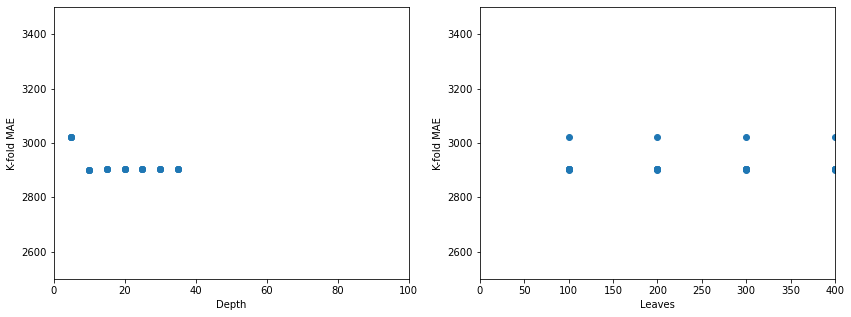

In [ ]:
# Regular Basic GOOD Model

#basic decision tree model with default parameters and random_state = 45
basicmodel = DecisionTreeRegressor(random_state=45) 
basicmodel = basicmodel.fit(X_train, y_train)

#decision tree RMSE 
np.sqrt(mean_squared_error(y_test, basicmodel.predict(X_test)))

# Random Forest L

#grid search 1
param_grid = {
    'max_depth': [12,15,18],
    'max_leaf_nodes': range(25,250, 50),
    'max_features': range(1,4),
    'n_estimators': range(1,30,10)
}
skf = StratifiedKFold(n_splits=5)

grid = GridSearchCV(RandomForestRegressor(random_state=45), param_grid, scoring= 'neg_mean_squared_error', cv=skf, n_jobs=-1, verbose = True)
grid.fit(X_train,y_train)
grid.best_estimator_

print(np.sqrt(grid.best_score_)) # Best accuracy that the grid returns
print(grid.best_params_) # Best hyperparam combo
cv_results = pd.DataFrame(grid.cv_results_)

# grid search 1 -> rf_A
rf_A = RandomForestRegressor(n_estimators=grid.best_params_['n_estimators'],max_depth=grid.best_params_['max_depth'],
max_leaf_nodes=grid.best_params_['max_leaf_nodes'],max_features=grid.best_params_['max_features'],random_state= 42)

rf_A=rf_A.fit(X_train,y_train)
# RMSE of rf_A
np.sqrt(mean_squared_error(y_test, rf_A.predict(X_test)))

# feature importances 
imp = rf_A.feature_importances_

fi_df = pd.DataFrame(columns = ['predictor', 'rank'])
fi_df.loc[:, 'predictor'] = X_train.columns
fi_df.loc[:, 'rank'] = imp
fi_df = fi_df.sort_values('rank', ascending = False)
print(fi_df)

# Random Forest -- max features and bootstrap check

# grid search 2
params = {'max_features': range(1,26), 
          'bootstrap': [True, False]}

cv = KFold(n_splits=5, shuffle=True, random_state=45)

rf_grid = GridSearchCV(RandomForestRegressor(random_state=45, n_jobs=-1, n_estimators=150), param_grid = params, cv=cv,
                       n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')

rf_grid.fit(X_train, y_train)
print(rf_grid.best_score_, rf_grid.best_params_)

# Grid Search 2 -> rf_B
rf_B = RandomForestRegressor(random_state=45, max_features =9,bootstrap = True) 
rf_B.fit(X_train, y_train)
# RMSE of rf_B
np.sqrt(mean_squared_error(y_test, rf_B.predict(X_test)))

# Grid Search 2 -> rf_C
rf_C = RandomForestRegressor(random_state=45, max_features =9,bootstrap = False) 
rf_C.fit(X_train, y_train)
#RMSE of rf_C
np.sqrt(mean_squared_error(y_test, rf_C.predict(X_test)))

# Random Forest -- max_leaf_nodes, max_depth

# Grid Search 3
params = {'max_leaf_nodes': range(100,500,100), 
          'max_depth': [5,10,15,20,25,30,35]}

cv = KFold(n_splits=5, shuffle=True, random_state=45)

rf_grid = GridSearchCV(RandomForestRegressor(random_state=45, n_jobs=-1, n_estimators=150, max_features =9,bootstrap = True), 
                       param_grid = params, cv=cv,
                       n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')
rf_grid.fit(X_train, y_train)
print(rf_grid.best_score_, rf_grid.best_params_)

# Grid Search 3 -> rf_D
rf_D = RandomForestRegressor(random_state=45, max_features =9, max_depth =10, max_leaf_nodes = 100, bootstrap = True) 
rf_D.fit(X_train, y_train)
# RMSE of rf_D
np.sqrt(mean_squared_error(y_test, rf_D.predict(X_test)))

# Grid Search 3 -> rf_E
rf_E = RandomForestRegressor(random_state=45, max_features =9, max_depth =10, max_leaf_nodes = 100, bootstrap = False) 
rf_E.fit(X_train, y_train)
# RMSE of rf_E
np.sqrt(mean_squared_error(y_test, rf_E.predict(X_test)))

# getting the CV response
cv_results = pd.DataFrame(rf_grid.cv_results_)
cv_results.head()

# getting a plot of depth and leaves 
fig, axes = plt.subplots(1,2,figsize=(14,5))
plt.subplots_adjust(wspace=0.2)
axes[0].plot(cv_results.param_max_depth, np.sqrt(-cv_results.mean_test_score), 'o')
axes[0].set_xlim([0,100])
axes[0].set_ylim([2500,3500])
axes[0].set_xlabel('Depth')
axes[0].set_ylabel('K-fold MAE')
axes[1].plot(cv_results.param_max_leaf_nodes, np.sqrt(-cv_results.mean_test_score), 'o')
axes[1].set_xlim([0,400])
axes[1].set_ylim([2500,3500])
axes[1].set_xlabel('Leaves')
axes[1].set_ylabel('K-fold MAE')

# zoom in corse grid search on max_leaf_nodes

# Grid Search 4
params = {'max_leaf_nodes': range(25,75,5), 
          'max_depth': [1,3,5,7]}

cv = KFold(n_splits=5, shuffle=True, random_state=45)

rf_grid = GridSearchCV(RandomForestRegressor(random_state=45, n_jobs=-1, n_estimators=150, max_features =9,bootstrap = True), 
                       param_grid = params, cv=cv,
                       n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')
rf_grid.fit(X_train, y_train)
print(rf_grid.best_score_, rf_grid.best_params_)

# Grid Search 4 -> rf_F
rf_F = RandomForestRegressor(random_state=45, max_features =9, max_depth =7, max_leaf_nodes = 25, bootstrap = True) 
rf_F.fit(X_train, y_train)
# RMSE of rf_F
np.sqrt(mean_squared_error(y_test, rf_F.predict(X_test)))

# Grid Search 4 -> rf_G
rf_G = RandomForestRegressor(random_state=45, max_features =9, max_depth =7, max_leaf_nodes = 25, bootstrap = False) 
rf_G.fit(X_train, y_train)
np.sqrt(mean_squared_error(y_test, rf_G.predict(X_test)))

# checking a bit more

#Grid Search5
params = {'max_leaf_nodes': range(50,75,10), 
          'max_depth': [5,7,10,13]}

cv = KFold(n_splits=5, shuffle=True, random_state=45)

rf_grid = GridSearchCV(RandomForestRegressor(random_state=45, n_jobs=-1, n_estimators=150, max_features =9,bootstrap = True), 
                       param_grid = params, cv=cv,
                       n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')
rf_grid.fit(X_train, y_train)
print(rf_grid.best_score_, rf_grid.best_params_)

# Grid Search 5 -> rf_H
rf_H = RandomForestRegressor(random_state=45, max_features =9, max_depth =10, max_leaf_nodes = 50, bootstrap = False) 
rf_H.fit(X_train, y_train)
# RMSE of rf_H
np.sqrt(mean_squared_error(y_test, rf_H.predict(X_test)))

# adding more params (trying different max_features)

# Grid Search 6
params = {'max_features':["sqrt", "log2"]}

cv = KFold(n_splits=5, shuffle=True, random_state=45)

rf_grid = GridSearchCV(RandomForestRegressor(random_state=45, n_jobs=-1, n_estimators=150,bootstrap = True), 
                       param_grid = params, cv=cv,
                       n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')
rf_grid.fit(X_train, y_train)
print(rf_grid.best_score_, rf_grid.best_params_)

# Grid Search 6 -> rf_I
rf_I = RandomForestRegressor(random_state=45, max_features ='sqrt', max_depth =10, max_leaf_nodes = 50, bootstrap = False) 
rf_I.fit(X_train, y_train)

np.sqrt(mean_squared_error(y_test, rf_I.predict(X_test)))

# ADABOOST

In [ ]:
ab = AdaBoostRegressor(DecisionTreeRegressor(random_state=12, max_depth = 5), n_estimators=50, learning_rate=0.1,
                                            random_state=15) # learning_rate like lasso or ridge param
ab.fit(X_train,y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=5,
                                                       random_state=12),
                  learning_rate=0.1, random_state=15)

In [ ]:
# predict, score, etc
# gridsearching - NOW WE HAVE TO TUNE THE REG HYPERPARAM OF BASE TREE
ab = AdaBoostRegressor(DecisionTreeRegressor(random_state=12),random_state=15)

param_grid = {'n_estimators': [40,50,60],
             'learning_rate': [0.001, 0.01, 0.1, 1, 10],
              # needs prefix to tell it to be a hyperparam of the decision tree (two underscores to differentiate)
             'base_estimator__max_depth':[5, 10, 20]} # or base_estimator or estimator before max_depth, can also work for bagging

grid = GridSearchCV(ab, param_grid, cv = 5, scoring = ['neg_mean_squared_error', 'r2'], refit = 'neg_mean_squared_error',
                   verbose = 2, n_jobs = -1)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


GridSearchCV(cv=5,
             estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(random_state=12),
                                         random_state=15),
             n_jobs=-1,
             param_grid={'base_estimator__max_depth': [5, 10, 20],
                         'learning_rate': [0.001, 0.01, 0.1, 1, 10],
                         'n_estimators': [40, 50, 60]},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'r2'], verbose=2)

>2 3568.556 (350.038)
>5 4004.864 (248.615)
>10 4077.232 (127.286)
>50 4325.816 (372.163)
>100 4325.816 (372.163)
>500 4325.816 (372.163)
>1000 4325.816 (372.163)


Text(0.5, 0, 'Number of trees')

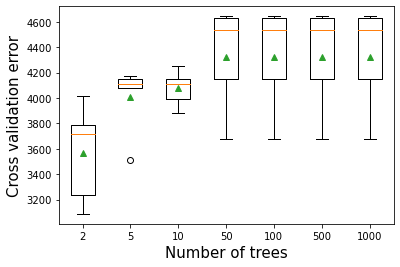

In [ ]:
def get_models():
    models = dict()
    # define number of trees to consider
    n_trees = [2, 5, 10, 50, 100, 500, 1000]
    for n in n_trees:
        models[str(n)] = AdaBoostRegressor(n_estimators=n,random_state=1) # the others are fixed to default vals
        # the default base_estimator is a dt with max_depth = 3
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models() # get 7 models
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items(): # for each model
    # evaluate the model
    scores = evaluate_model(model, X, y) # evaluate CV score
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Number of trees',fontsize=15)

>1 4495.779 (572.228)
>2 4782.327 (400.733)
>3 4351.003 (500.220)
>4 4079.170 (243.898)
>5 3601.933 (523.993)
>6 3332.582 (598.862)
>7 3063.188 (640.784)
>8 2910.209 (655.111)
>9 2907.591 (790.124)
>10 2880.681 (758.973)
>11 2785.797 (726.996)
>12 2924.466 (715.841)
>13 2906.408 (771.849)
>14 2883.877 (746.716)
>15 2807.266 (685.484)
>16 3011.508 (772.867)
>17 2766.220 (800.843)
>18 2935.541 (717.746)
>19 2911.078 (782.896)
>20 2844.050 (763.337)


Text(0.5, 0, 'Depth of each tree')

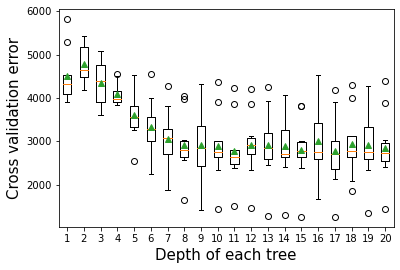

In [ ]:
# Performance goes down then back up
# Find the optimal # of trees - n_estimators has to be in gridsearch for adaboosting bc of overfitting
# It should print stuff so you know where you are in the loop

# Depth - hyperparam for the trees
# get a list of models to evaluate
def get_models():
    models = dict()
    # explore depths from 1 to 10
    for i in range(1,21):
        # define base model
        base = DecisionTreeRegressor(max_depth=i)
        # define ensemble model
        models[str(i)] = AdaBoostRegressor(base_estimator=base,n_estimators=50) # fixed n_estimators (# of trees)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X, y) # get the CV scores for each depth val
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Depth of each tree',fontsize=15)

>0.0 -11818896.137 (6039056.309)
>0.1 -13640141.894 (4575206.735)
>1.0 -17711552.475 (4044077.279)
>1.5 -19367037.903 (3909212.266)


Text(0.5, 0, 'Learning rate')

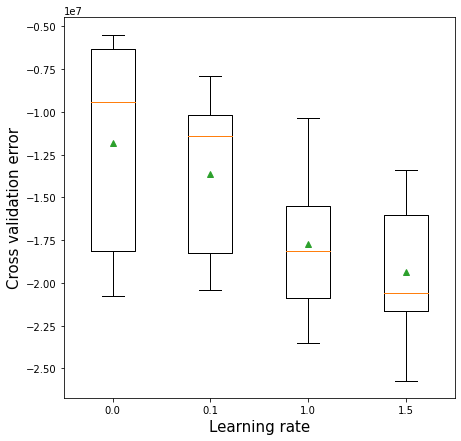

In [ ]:
def get_models():
    models = dict()
    # explore learning rates from 0.1 to 2 in 0.1 increments
    for i in [0.00001, 0.0001, 0.001, 0.01,0.1, 1.0, 1.5]:
    #np.arange(0.1, 2.1, 0.1):
        key = '%.1f' % i
        models[key] = AdaBoostRegressor(learning_rate=i)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X_train, y_train):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Learning rate',fontsize=15)

In [ ]:
model = AdaBoostRegressor(random_state=1)
grid = dict()
grid['n_estimators'] = [10, 250]
grid['learning_rate'] = [0.00001, 1.5]
grid['base_estimator'] = [DecisionTreeRegressor(max_depth=3), DecisionTreeRegressor(max_depth=5), 
                          DecisionTreeRegressor(max_depth=13), DecisionTreeRegressor(max_depth=15)]
# define the evaluation procedure
cv = KFold(n_splits=5, shuffle=True, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='neg_mean_squared_error')
# execute the grid search
grid_result = grid_search.fit(X_train, y_train)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param)

Best: -9126017.898895 using {'base_estimator': DecisionTreeRegressor(max_depth=13), 'learning_rate': 1e-05, 'n_estimators': 250}


In [ ]:
grid_result.best_estimator_

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=13),
                  learning_rate=1e-05, n_estimators=250, random_state=1)

In [ ]:
np.sqrt(8517407.078933)

2918.4597100068045

In [ ]:
model = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=13),
                  learning_rate=0.0001, n_estimators=200, random_state=1).fit(X_train,y_train)
pred = model.predict(X_test)
print("AdaBoost model RMSE = ", np.sqrt(mean_squared_error(model.predict(X_test),y_test)))

AdaBoost model RMSE =  2488.356725214291


>2 3568.556 (350.038)
>5 4004.864 (248.615)
>10 4077.232 (127.286)
>50 4325.816 (372.163)
>100 4325.816 (372.163)
>500 4325.816 (372.163)
>1000 4325.816 (372.163)


Text(0.5, 0, 'Number of trees')

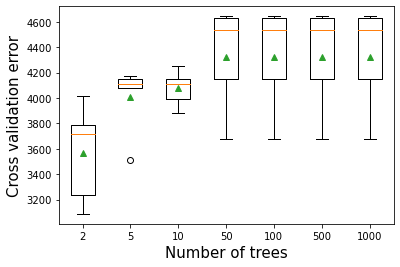

In [ ]:
def get_models():
    models = dict()
    # define number of trees to consider
    n_trees = [2, 5, 10, 50, 100, 500, 1000]
    for n in n_trees:
        models[str(n)] = AdaBoostRegressor(n_estimators=n,random_state=1) # the others are fixed to default vals
        # the default base_estimator is a dt with max_depth = 3
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models() # get 7 models
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items(): # for each model
    # evaluate the model
    scores = evaluate_model(model, X, y) # evaluate CV score
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Number of trees',fontsize=15)

>1 4638.452 (520.324)
>2 4409.660 (570.378)
>3 4214.979 (555.507)
>4 3971.452 (518.357)
>5 3565.693 (545.858)
>6 3326.571 (630.047)
>7 3084.303 (654.824)
>8 2957.764 (698.500)
>9 2950.748 (741.500)
>10 2909.009 (760.182)
>11 2855.181 (768.645)
>12 2883.580 (709.034)
>13 2901.098 (760.083)
>14 2815.951 (817.772)
>15 2846.658 (794.476)
>16 2908.620 (756.739)
>17 2881.849 (738.456)
>18 2895.940 (781.379)
>19 2936.301 (773.871)
>20 2829.180 (777.696)


Text(0.5, 0, 'Depth of each tree')

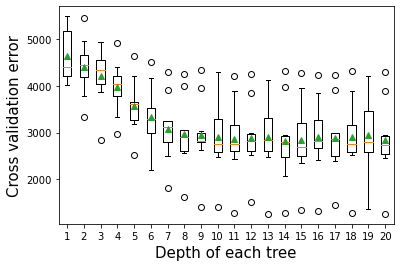

In [ ]:
def get_models():
    models = dict()
    # explore depths from 1 to 10
    for i in range(1,21):
        # define base model
        base = DecisionTreeRegressor(max_depth=i)
        # define ensemble model
        models[str(i)] = AdaBoostRegressor(base_estimator=base,n_estimators=50) # fixed n_estimators (# of trees)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X, y) # get the CV scores for each depth val
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Depth of each tree',fontsize=15)

>0.1 -13548626.458 (3013930.818)
>0.2 -15213177.597 (3433001.805)
>0.3 -14893465.113 (2844439.301)
>0.4 -17144893.995 (2981202.073)
>0.5 -16786445.958 (3760149.838)
>0.6 -17356756.842 (2697880.648)
>0.7 -17173437.696 (2770991.816)
>0.8 -17205193.261 (2445856.916)
>0.9 -18806206.115 (2796334.121)
>1.0 -18439099.175 (3208447.201)
>1.1 -19328565.984 (2418820.160)
>1.2 -21483505.787 (3853911.600)
>1.3 -18962940.813 (3313736.483)
>1.4 -20358614.363 (3294558.224)
>1.5 -20168709.336 (3094047.765)
>1.6 -21641344.721 (2389032.593)
>1.7 -21158480.476 (3709859.628)
>1.8 -21528226.881 (3655466.740)
>1.9 -19785328.094 (3318923.774)
>2.0 -21042895.842 (3020170.649)


Text(0.5, 0, 'Learning rate')

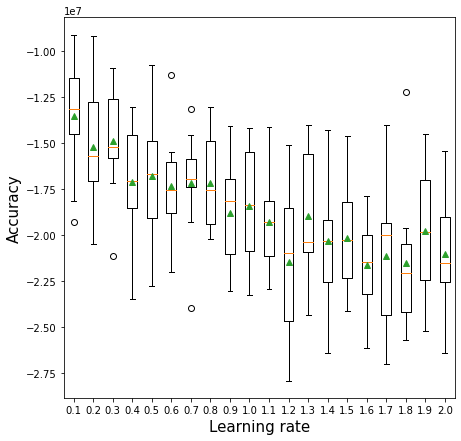

In [ ]:
def get_models():
    models = dict()
    # explore learning rates from 0.1 to 2 in 0.1 increments
    for i in np.arange(0.1, 2.1, 0.1):
        key = '%.1f' % i
        models[key] = AdaBoostRegressor(learning_rate=i)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X, y)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Accuracy',fontsize=15)
plt.xlabel('Learning rate',fontsize=15)

In [ ]:
model = AdaBoostRegressor(random_state=1)
grid = dict()
grid['n_estimators'] = [10, 50, 100, 200, 250]
grid['learning_rate'] = [0.0001, 0.001, 0.01,0.1, 1.0, 1.5]
grid['base_estimator'] = [DecisionTreeRegressor(max_depth=9), DecisionTreeRegressor(max_depth=10), 
                          DecisionTreeRegressor(max_depth=11), DecisionTreeRegressor(max_depth=12),
                          DecisionTreeRegressor(max_depth=13), DecisionTreeRegressor(max_depth=14),
                          DecisionTreeRegressor(max_depth=14)]
# define the evaluation procedure
cv = KFold(n_splits=5, shuffle=True, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='neg_mean_squared_error',verbose=1)
# execute the grid search
grid_result = grid_search.fit(X_train, y_train)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param)

Fitting 5 folds for each of 210 candidates, totalling 1050 fits
Best: -8517407.078933 using {'base_estimator': DecisionTreeRegressor(max_depth=13), 'learning_rate': 0.0001, 'n_estimators': 200}
[CV] END base_estimator__max_depth=5, learning_rate=0.001, n_estimators=40; total time=   0.1s
[CV] END base_estimator__max_depth=5, learning_rate=0.001, n_estimators=50; total time=   0.2s
[CV] END base_estimator__max_depth=5, learning_rate=0.001, n_estimators=50; total time=   0.2s
[CV] END base_estimator__max_depth=5, learning_rate=0.001, n_estimators=60; total time=   0.2s
[CV] END base_estimator__max_depth=5, learning_rate=0.01, n_estimators=40; total time=   0.1s
[CV] END base_estimator__max_depth=5, learning_rate=0.01, n_estimators=50; total time=   0.2s
[CV] END base_estimator__max_depth=5, learning_rate=0.01, n_estimators=60; total time=   0.2s
[CV] END base_estimator__max_depth=5, learning_rate=0.1, n_estimators=40; total time=   0.1s
[CV] END base_estimator__max_depth=5, learning_rate

# GradBoost

### Gradient Boost
*By Rakin Hussain*

>2 5565.726 (351.926)
>5 4715.882 (335.196)
>10 3884.724 (280.810)
>50 2922.711 (473.015)
>100 2960.011 (509.654)
>500 3070.330 (409.776)
>1000 3309.657 (561.165)
>2000 3367.484 (563.520)
>5000 3633.973 (618.766)


Text(0.5, 0, 'Number of trees')

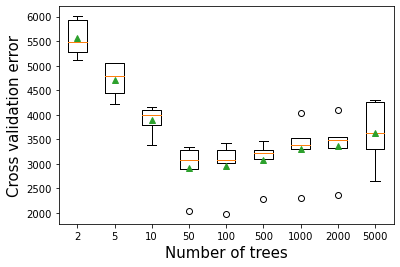

In [ ]:
def get_models():
    models = dict()
    n_trees = [2, 5, 10, 50, 100, 500, 1000, 2000, 5000]
    for n in n_trees:
        models[str(n)] = GradientBoostingRegressor(n_estimators=n,random_state=45,loss='huber')
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Number of trees',fontsize=15)

# Depth vs CV Error

>1 3613.302 (730.698)
>2 3087.689 (867.636)
>3 2755.158 (1021.845)
>4 2735.641 (1082.870)
>5 2979.906 (968.346)
>6 3182.421 (834.241)
>7 3523.285 (718.661)
>8 3553.629 (738.480)
>9 3619.494 (824.314)
>10 3761.127 (713.243)
>11 3754.022 (689.055)
>12 3742.056 (681.766)
>13 3749.430 (670.698)
>14 3745.984 (667.583)
>15 3740.363 (670.487)
>16 3740.964 (669.826)
>17 3744.442 (666.349)
>18 3743.454 (667.251)
>19 3743.707 (667.282)
>20 3744.071 (666.796)


Text(0.5, 0, 'Depth of each tree')

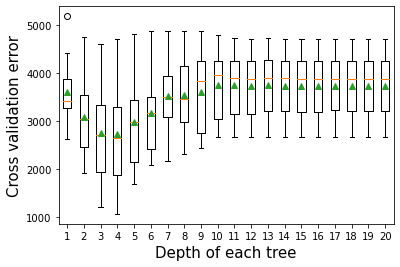

In [ ]:
# get a list of models to evaluate
def get_models():
    models = dict()
    # explore depths from 1 to 10
    for i in range(1,21):
        # define ensemble model
        models[str(i)] = GradientBoostingRegressor(n_estimators=50,random_state=45,max_depth=i,loss='huber')
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=45)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Depth of each tree',fontsize=15)


# Learning Rate vs CV Error

>0.1 2815.2 (1008.6)
>0.2 2832.8 (961.0)
>0.3 2946.7 (878.8)
>0.4 3049.7 (945.5)
>0.5 2941.1 (929.0)
>0.6 3024.1 (925.1)
>0.7 3167.7 (949.0)
>0.8 3295.3 (843.9)
>0.9 3455.6 (923.2)
>1.0 3579.2 (813.1)
>1.1 3547.0 (956.0)
>1.2 3432.2 (732.8)
>1.3 3782.4 (1082.3)
>1.4 3780.6 (827.8)
>1.5 3689.3 (914.9)
>1.6 3843.2 (1065.8)
>1.7 4647.0 (1007.1)
>1.8 4279.4 (789.1)
>1.9 4623.6 (680.8)


Text(0.5, 0, 'Learning rate')

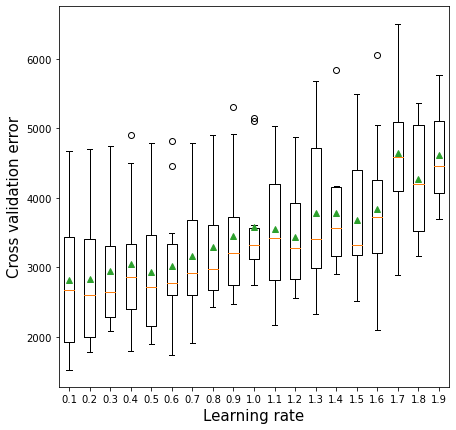

In [ ]:
def get_models():
    models = dict()
    # explore learning rates from 0.1 to 2 in 0.1 increments
    for i in np.arange(0.1, 2, 0.1):
        key = '%.1f' % i
        models[key] = GradientBoostingRegressor(learning_rate=i,random_state=45,loss='huber')
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=45)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Learning rate',fontsize=15)

# Subsampling vs CV Error

>0.25 2846.70 (959.84)
>0.50 2778.51 (978.50)
>0.75 2735.20 (1008.52)
>1.00 2815.24 (1008.61)


Text(0.5, 0, 'Subsample')

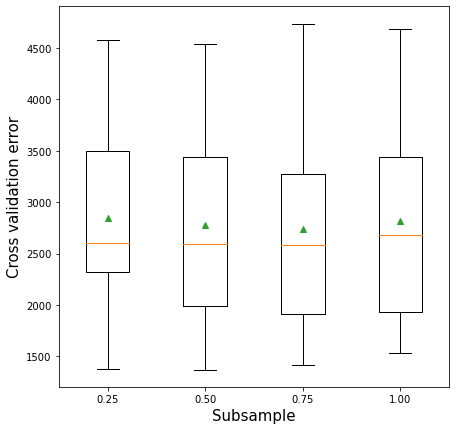

In [ ]:
def get_models():
    models = dict()
    # explore learning rates from 0.1 to 2 in 0.1 increments
    for s in np.arange(0.25, 1.1, 0.25):
        key = '%.2f' % s
        models[key] = GradientBoostingRegressor(random_state=45,subsample=s,loss='huber')
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=45)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.2f (%.2f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Subsample',fontsize=15)

# Initial Randomized Search

In [ ]:
gd = GradientBoostingRegressor(random_state=45, loss='huber')
grid = dict()
grid['n_estimators'] = range(10, 510, 10)
grid['learning_rate'] = [0.00001, 0.0001, 0.001, 0.01, 0.1]
grid['max_depth'] = range(1,6)

search = RandomizedSearchCV(gd, grid, n_jobs=-1, scoring='neg_mean_squared_error',verbose = True, n_iter=40)

grid_result = search.fit(X_train, y_train)
print("Best: %f using %s" % (np.sqrt(-grid_result.best_score_), grid_result.best_params_))

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best: 2986.829358 using {'n_estimators': 350, 'max_depth': 4, 'learning_rate': 0.01}


In [ ]:
model = GradientBoostingRegressor(n_estimators=420, max_depth=4, learning_rate=0.01, random_state=45, loss='huber')
model.fit(X_train, y_train)

pred = model.predict(X_test)
print('Gradient Boosting RMSE:', np.sqrt(mean_squared_error(pred, y_test)))

Gradient Boosting RMSE: 2420.3714607677753


# Tuning Randomized Search

In [5]:
#coarse search


model = GradientBoostingRegressor(loss='huber', random_state=45)

param_grid = {'max_depth':[4,6,8],
              'n_estimators':[100,500,1000], 
              'learning_rate':[0.01,0.25,0.5],
              'subsample':[0.5,0.75,1]
             }

cv = KFold(n_splits=2, shuffle=True, random_state=45)
grid = RandomizedSearchCV(model, param_grid, n_jobs=-1,verbose=1,cv=cv, scoring='neg_mean_absolute_error')
grid.fit(X_train, y_train)

print(grid.best_score_, grid.best_params_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
-1369.7326102119368 {'subsample': 1, 'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.01}


In [6]:
# fine search

model = GradientBoostingRegressor(loss='huber', random_state=45)

param_grid = {'max_depth': range(1,6),
              'n_estimators': range(10, 510, 10),
              'learning_rate':[0.00001, 0.0001, 0.001, 0.01, 0.1],
              'subsample':[0.5,0.75,1]
             }

cv = KFold(n_splits=5, shuffle=True, random_state=45)
grid = RandomizedSearchCV(model, param_grid, n_jobs=-1,verbose=1,cv=cv, scoring='neg_mean_absolute_error')
grid.fit(X_train, y_train)

print(grid.best_score_, grid.best_params_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
-1195.9477958166578 {'subsample': 1, 'n_estimators': 60, 'max_depth': 5, 'learning_rate': 0.1}


In [8]:
# fine RMSE

model = GradientBoostingRegressor(n_estimators=60, max_depth=5, learning_rate=0.1, subsample=1,
                                  random_state=1, loss='huber')
model.fit(X_train, y_train)

pred = model.predict(X_test)
print('Gradient Boosting RMSE:', np.sqrt(mean_squared_error(pred, y_test)))

Gradient Boosting RMSE: 2318.729205636546


In [9]:
fi_df = pd.DataFrame(columns = ['predictor', 'rank'])
fi_df.loc[:, 'predictor'] = X_train.columns
fi_df.loc[:, 'rank'] = model.feature_importances_
fi_df = fi_df.sort_values('rank', ascending = False)
print(fi_df)

                 predictor      rank
0                      Age  0.792205
3           AnyTransplants  0.063519
6                   Weight  0.053105
4       AnyChronicDiseases  0.032017
8  HistoryOfCancerInFamily  0.030695
9   NumberOfMajorSurgeries  0.021885
5                   Height  0.003779
2    BloodPressureProblems  0.001874
1                 Diabetes  0.000463
7           KnownAllergies  0.000458
